In [1]:
import joblib 
import numpy as np
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
import hist
from hist import Hist 
from uncertainties import ufloat, unumpy
from tqdm import tqdm
import re
import argparse

from concurrent.futures import ProcessPoolExecutor
import functools 


import sys
core_code_path = '/global/cfs/projectdirs/atlas/hrzhao/HEP_Repo/QG_Calibration/NewWorkflow'
sys.path.append(core_code_path)

from core.Calculate_SF import convert_histdict2unumpy, Construct_unumpy, Normalize_unumpy, Plot_WP, WriteSFtoPickle
from core.utils import HistBins, label_var, label_leadingtype, label_etaregion, label_pt_bin, label_jettype, label_jettype_data, WPs,reweighting_vars
from core.utils import logging_setup, make_empty_hist

In [2]:
pd_path = '/global/cfs/projectdirs/atlas/hrzhao/HEP_Repo/QG_Calibration/NewWorkflow/trained_lightGBM_new/statistical'
pd_path = Path(pd_path)

pd_files = sorted(pd_path.rglob('SFs_pd_bootstrapped_samples*'))

In [3]:
SF_pd_list = []
random_selected_files = np.random.choice(pd_files, size=1)
for file in tqdm(random_selected_files):
    SF_pd_list.append(joblib.load(file))

SF_pd_all = pd.concat(SF_pd_list)

100%|██████████| 1/1 [00:00<00:00, 45.81it/s]


In [4]:
SF_pd_all

,Trail,Var,WP,Reweight,pt_idx,values
0,0,jet_nTracks,0.5,Quark,0,1.0302572560683878
1,0,jet_nTracks,0.5,Quark,1,1.0430335169023242
2,0,jet_nTracks,0.5,Quark,2,1.0470045861720205
3,0,jet_nTracks,0.5,Quark,3,1.035515099651363
4,0,jet_nTracks,0.5,Quark,4,1.0181826297405834
...,...,...,...,...,...,...
9595,99,GBDT_newScore,0.8,Gluon,1,0.9448322503922127
9596,99,GBDT_newScore,0.8,Gluon,2,0.9301371632450868
9597,99,GBDT_newScore,0.8,Gluon,3,0.9034804593009033
9598,99,GBDT_newScore,0.8,Gluon,4,0.835748732852213


In [5]:
grouped_SF_pd_all = SF_pd_all.groupby(["Var", "WP", "Reweight", "pt_idx"])

In [6]:
merged_sfs = dict.fromkeys(["jet_nTracks", "GBDT_newScore"])
partons = ['Quark', 'Gluon']

for var in reweighting_vars:
    merged_sfs[var] = dict.fromkeys(WPs)
    for WP in WPs:
        merged_sfs[var][WP] = dict.fromkeys(partons)
        for parton in partons:
            merged_sfs[var][WP][parton] = {}
            for pt_idx, l_pt in enumerate(label_pt_bin[:-1]):
                merged_sfs[var][WP][parton][pt_idx] = []


SFs_bootstrap = {}
for var in ["jet_nTracks", "GBDT_newScore"]:
    SFs_bootstrap[var] = {}
    for WP in WPs:
        SFs_bootstrap[var][WP] = {}
        for parton in partons:
            SFs_bootstrap[var][WP][parton] = {}
            for pt_idx, l_pt in enumerate(label_pt_bin[:-1]):
                nominal_values = grouped_SF_pd_all.get_group((var, WP, parton, pt_idx))['values'].agg(unumpy.nominal_values).to_numpy()
                merged_sfs[var][WP][parton][pt_idx].append(
                    nominal_values
                )
            # print([*merged_sfs[var][WP][parton].values()])
            nominal_values_all_pt = np.vstack([*merged_sfs[var][WP][parton].values()])
            sf_unumpy = unumpy.uarray(
                np.mean(nominal_values_all_pt, axis=1), 
                np.std(nominal_values_all_pt, axis=1))
            SFs_bootstrap[var][WP][parton] = sf_unumpy


In [7]:
SFs_bootstrap['jet_nTracks'][0.5]['Quark']

array([1.027936864397145+/-0.0015281015680929256,
       1.044299495823213+/-0.0010567488998559388,
       1.0459281074325444+/-0.0019400137779004096,
       1.033455384190764+/-0.004064439340364111,
       1.0207333841732933+/-0.007172990548411495,
       1.010821105516464+/-0.017490999545778714], dtype=object)

In [87]:
# joblib.dump(SFs_bootstrap, "SFs_bootstrap")

['SFs_bootstrap']

# Read the nominal (Error Propagation)

In [8]:
nominal_path = '/global/cfs/projectdirs/atlas/hrzhao/HEP_Repo/QG_Calibration/NewWorkflow/trained_lightGBM_new/nominal'
nominal_path = Path(nominal_path)

In [9]:
SFs_error_propagation = {}
for var in ["jet_nTracks", "GBDT_newScore"]:

    SFs_pkl_path = nominal_path / "plots" / "ADE" / "SFs_pkls" / f"{var}_quark_reweighting_weights" / "SFs.pkl"
    SFs_pkl_error_propagation = joblib.load(SFs_pkl_path)

    SFs_error_propagation[var] = SFs_pkl_error_propagation[var]

In [90]:
# joblib.dump(SFs_error_propagation, "SFs_error_propagation")

['SFs_error_propagation']

In [10]:
def plot_compare_2unumpy(unumpy1, unumpy2, bins, var, WP, parton):
    assert len(unumpy1) == len(unumpy2)

    fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.1})
    bin_edges = np.array(bins)

    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    ax0.errorbar(x=bin_centers, y=unumpy.nominal_values(unumpy1), yerr=unumpy.std_devs(unumpy1), color = 'blue', label = 'SF error prop', drawstyle='steps-mid')
    ax0.errorbar(x=bin_centers, y=unumpy.nominal_values(unumpy2), yerr=unumpy.std_devs(unumpy2), color = 'red', label = 'SF bootstrap', drawstyle='steps-mid')
    ax0.legend()
    ax0.set_xlim(bin_edges[0], bin_edges[-1])

    ax1.stairs(unumpy.nominal_values(unumpy1 - unumpy2) , bin_edges, lw=2, label='difference')
    ax1.set_ylim(-1e-4, 1e-4)
    ax1.hlines(y = 0, xmin = bin_edges[0], xmax = bin_edges[-1], color = 'black', linestyle = '--', label='difference = 0')
    ax1.set_ylabel("Difference")

    fig.suptitle(f"{var}, {WP}, {parton}")
    plt.plot()

    

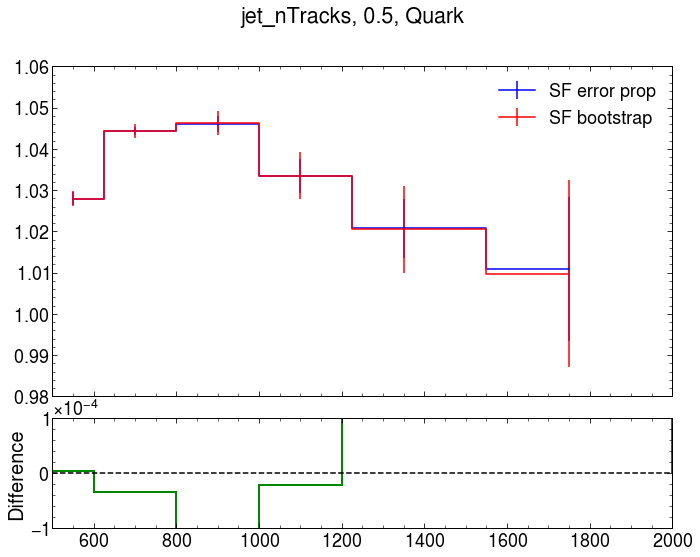

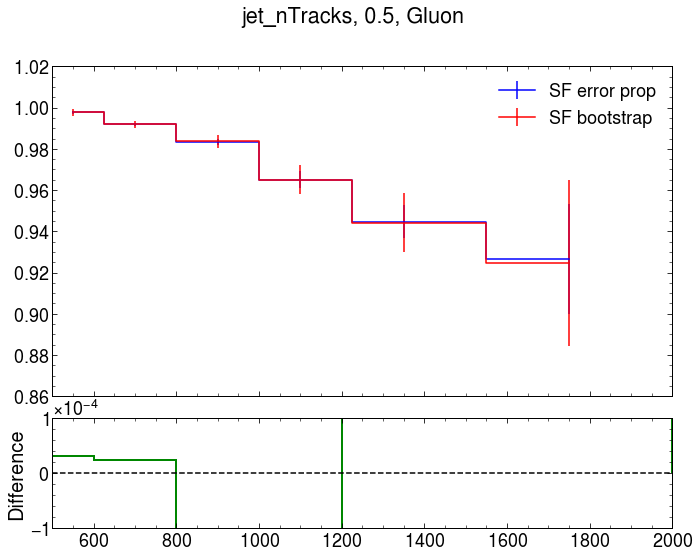

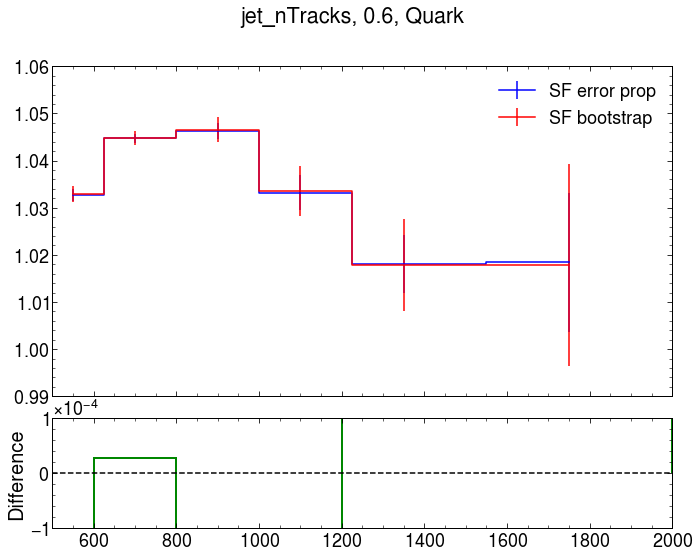

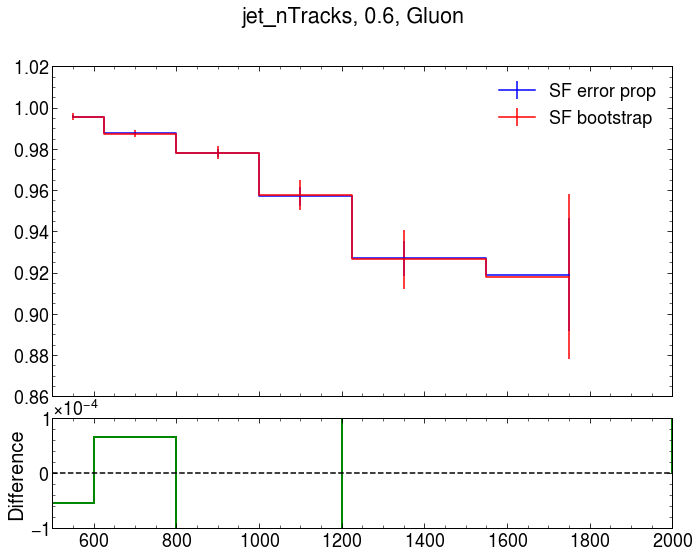

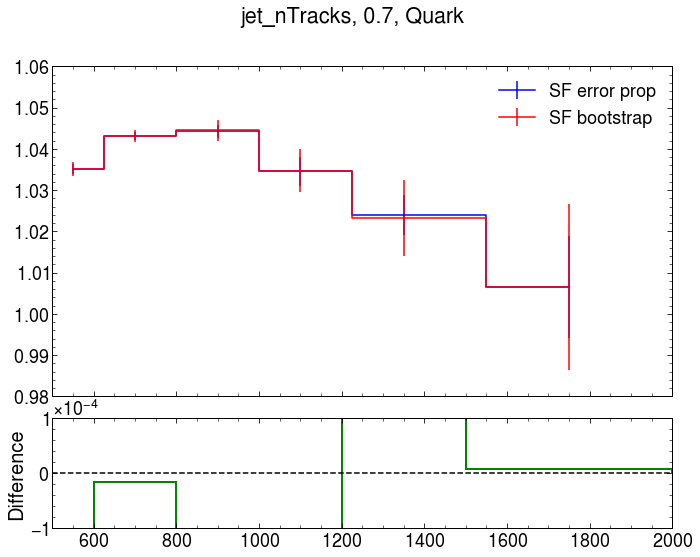

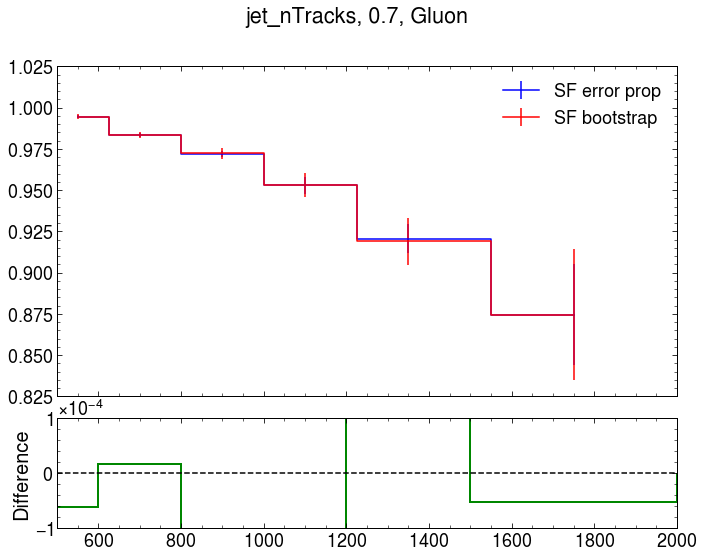

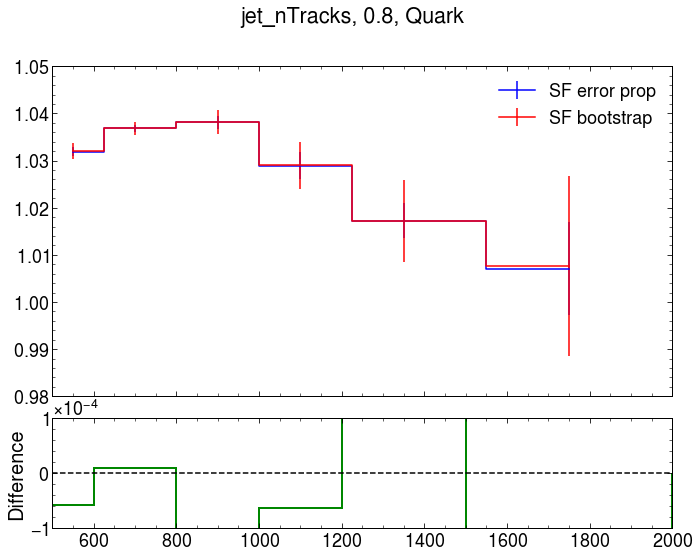

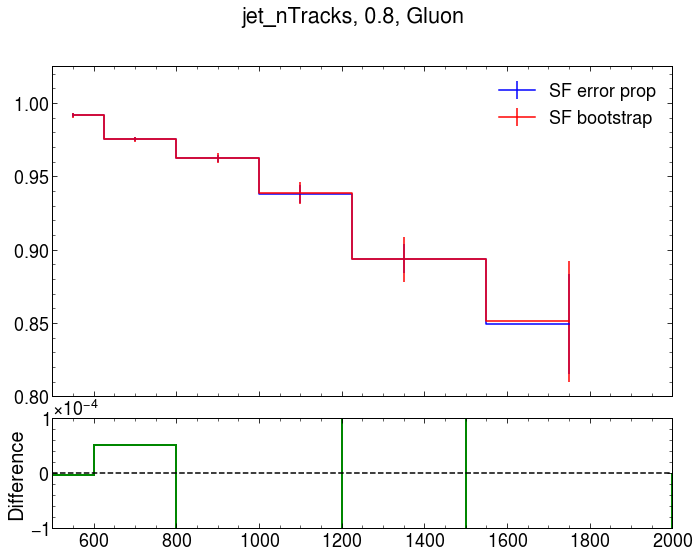

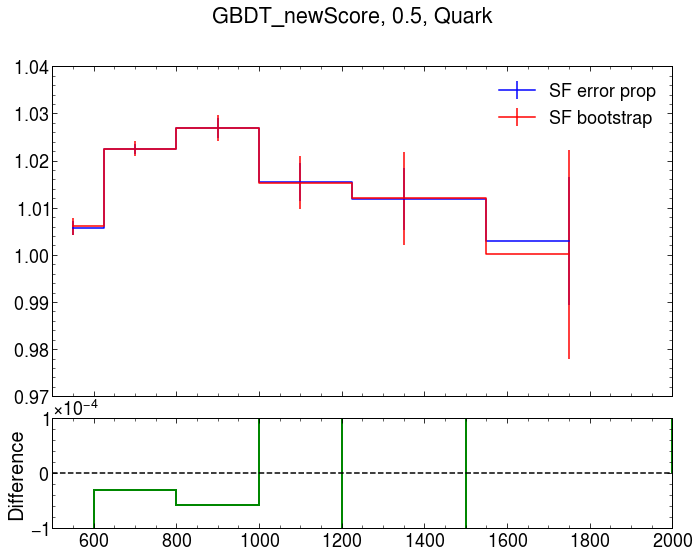

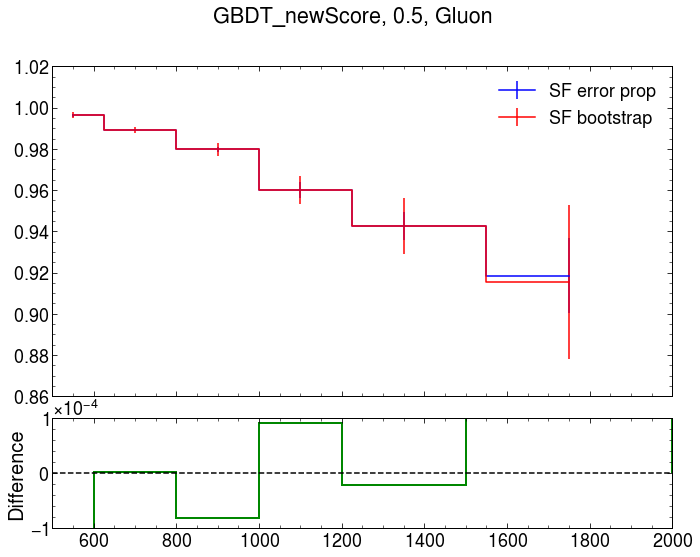

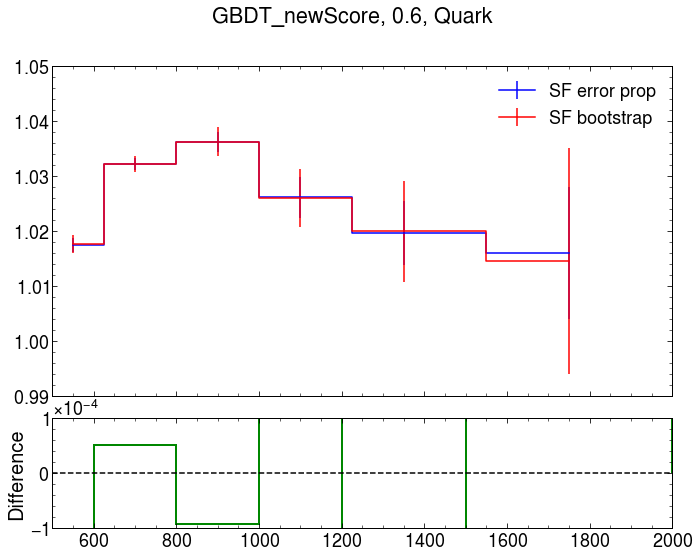

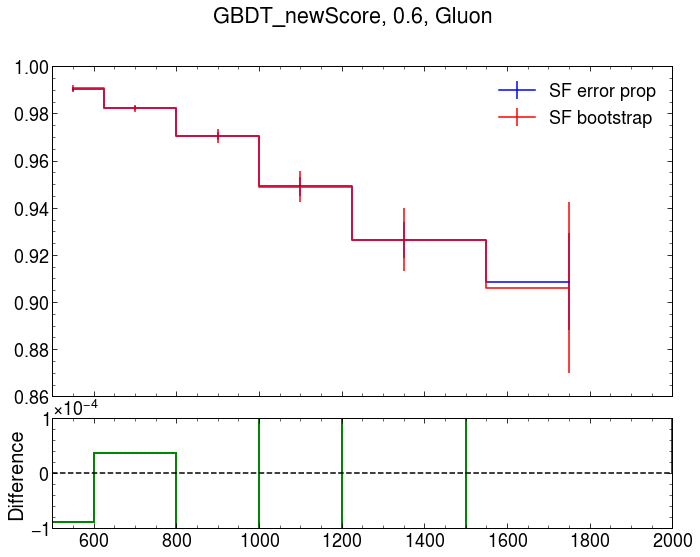

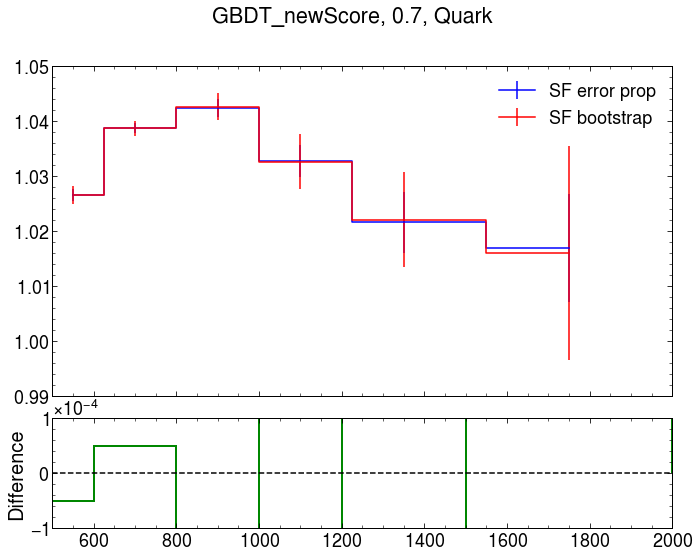

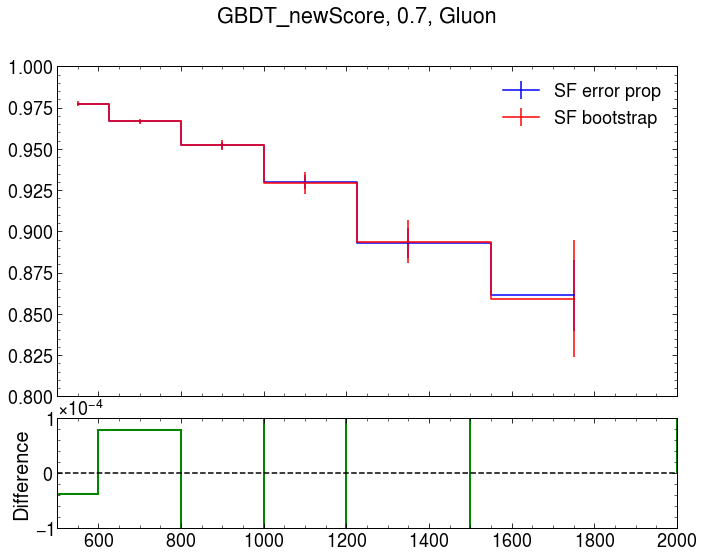

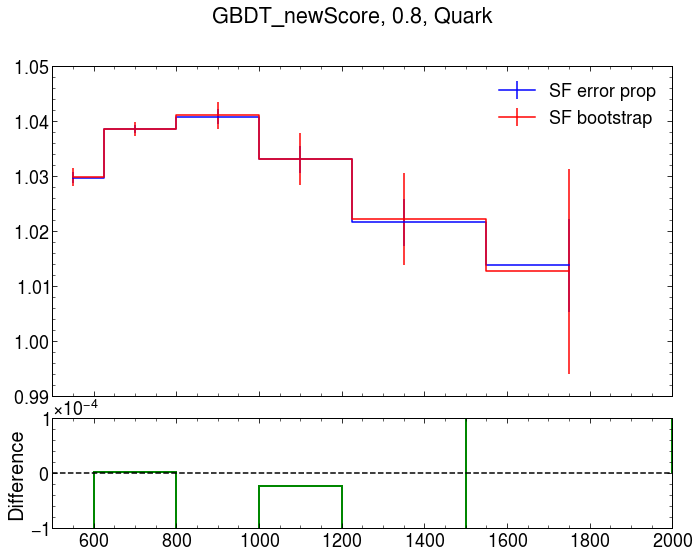

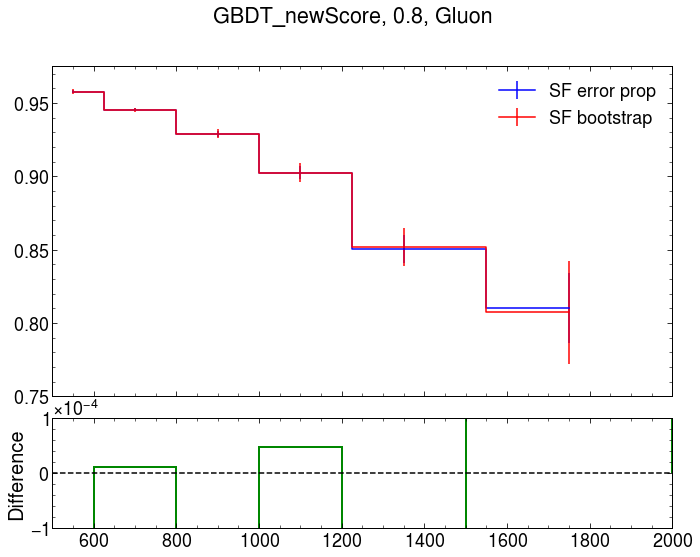

In [11]:
for var in ["jet_nTracks", "GBDT_newScore"]:
    for WP in WPs:
        for parton in partons:
            plot_compare_2unumpy(SFs_bootstrap[var][WP][parton], 
                                 SFs_error_propagation[var][WP][parton], 
                                 label_pt_bin, var, WP, parton)